<a id='introduction'></a>
# Introduction

This example showcases the use of the XAITK-Saliency API to generate visual saliency maps using models from the [scikit-learn](https://scikit-learn.org/stable/) library trained on the MNIST dataset.
The MNIST dataset contains grayscale images of handwritten digits (0-9) which are normalized and centered in the frame.
It was developed to evaluate the performance of models classifying individual handwritten digits.

[This example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html) from scikit-learn's website uses their `LogisticRegression` class to achieve fairly high accuracy on the MNIST dataset with very short training time.
As is shown by this example, it is easy to visualize the decision boundaries of each class by simply plotting their respective model's coefficients in the same dimensions as the input image.

We use the XAITK-Saliency high-level API to mimic this visualization by creating saliency maps for several images from the dataset and averaging them to create a global decision boundary representation for each class.
This approach achieves comparable results to those shown in scikit-learn's example while requiring zero knowledge of the intrinsic properties of the model used.

We do the same while using the `MLPClassifier` class also from the scikit-learn library.
Our model is taken from [another example](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html#sphx-glr-auto-examples-neural-networks-plot-mnist-filters-py) on their website.
They show in the example a visualization of the MLP's weights as images to gain insight on the learning behavior of the model.
However, these images only show generic patterns that the model has learned, however and the behavior of each class is still obscure.

Using our approach provides per-class saliency representations and also gives some insight on the different learning behaviors portrayed by both these models.

To run this notebook in Colab, please use the link below:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XAITK/xaitk-saliency/blob/master/examples/MNIST_scikit_saliency.ipynb)

## Downloading the Dataset

The MNIST dataset consists of 70000 28x28 grayscale images of handwritten numbers.
Each image is stored as a column vector, resulting in a (70000,784) shape for the entire dataset.

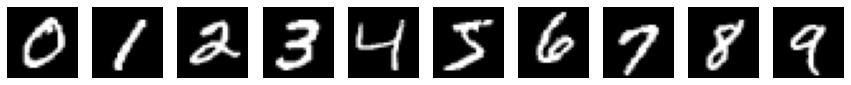

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
import os

cwd = os.getcwd()
data_dir = cwd + '/scikit-learn-example'

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, data_home=data_dir)
X = X/X.max()

# Find examples of each class
ref_inds = []
for i in range(10):
    ref_inds.append(np.where(np.int64(y) == i)[0][0])
    
ref_imgs = X[ref_inds]

# Plot examples
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(ref_imgs[i].reshape(28, 28), 'gray')
    plt.axis('off')
    

## The "Application"

Our "application" will accept a set of images, a blackbox image classifier, and a saliency generator and will generate saliency maps for each image provided.
The saliency maps from the first image in the set will then be plotted to give an idea of the model's behavior on a single sample.

Additionally, because all digits in the MNIST dataset are centered in the frame, we can average all the heatmaps generated for each respective class to produce a decision boundary visualization.
The application will do this and plot the resulting averaged heatmaps for each digit class.
This should compare to what is shown in the [first example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html) discussed in the [introduction](#introduction).

In [2]:
from smqtk_classifier import ClassifyImage
from xaitk_saliency import GenerateImageClassifierBlackboxSaliency

def app(
    images: np.ndarray,
    image_classifier: ClassifyImage,
    saliency_generator: GenerateImageClassifierBlackboxSaliency
):  

    # Generate saliency maps
    sal_maps_set = []
    for img in images:
        ref_image = img.reshape(28, 28)
        sal_maps = saliency_generator(ref_image, image_classifier)
        sal_maps_set.append(sal_maps)
    
    num_classes = sal_maps_set[0].shape[0]
    
    # Plot first image in set with saliency maps
    plt.figure(figsize=(10,5))
    plt.suptitle("Heatmaps for First Image", fontsize=16)
    num_cols = np.ceil(num_classes/2).astype(int) + 1
    plt.subplot(2, num_cols, 1)
    plt.imshow(images[0].reshape(28,28), cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
    for c in range(num_cols - 1):
        plt.subplot(2, num_cols, c + 2)
        plt.imshow(sal_maps_set[0][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(f"Class {c}")
    for c in range(num_classes - num_cols + 1, num_classes):
        plt.subplot(2, num_cols, c + 3)
        plt.imshow(sal_maps_set[0][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(f"Class {c}")
    
    # Average heatmaps for each respective class
    global_maps = np.sum(sal_maps_set, axis=0) / len(images)
    
    # Plot average maps
    plt.figure(figsize=(10, 5))
    plt.suptitle("Average Heatmaps from All Images", fontsize=16)
    for c in range(num_classes):
        vcap = np.absolute(global_maps[i]).max()
        plt.subplot(2, num_cols-1, c + 1)
        plt.imshow(global_maps[c], cmap=plt.cm.RdBu, vmin=-vcap, vmax=vcap)
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(f"Class {c}")

# Logistic Regression
## Fitting the Model

We take the same `LogisticRegression` object used in the scikit-learn example and fit it to a subset of the dataset.
Here, an L2 penalty and a larger training set in used to yield slightly better results than those shown in the example.
The same visualization of the coefficients is shown with these new parameters.

Test score with L2 penalty: 0.8942
Example run in 2.469 s


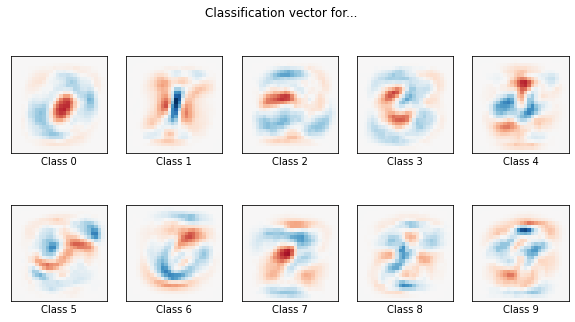

In [3]:
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

t0 = time.time()

# Split data into test and train sets
train_samples = 20000

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)

# Define model, lower C value gives higher regulation
clf = LogisticRegression(
    C=50. / train_samples, penalty='l2', solver='saga', tol=0.1
)

# Fit model
clf.fit(X_train, y_train)

# Score model
score = clf.score(X_test, y_test)
print("Test score with L2 penalty: %.4f" % score)

# Visualize coefficients
coef = clf.coef_.copy()
max_val = np.abs(coef).max()

plt.figure(figsize=(10, 5))
for i in range(10):
    p = plt.subplot(2, 5, i + 1)
    p.imshow(coef[i].reshape(28, 28), cmap=plt.cm.RdBu,
             vmin=-max_val, vmax=max_val)
    p.set_xticks(())
    p.set_yticks(())
    p.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')

run_time = time.time() - t0
print('Example run in %.3f s' % run_time)
plt.show()

## Blackbox Classifier

Here we wrap our `LogisticRegression` object in [SMQTK-Classifier's](https://smqtk-classifier.readthedocs.io/en/stable/classifier_interfaces.html#classifyimage) `ClassifyImage` class to comply with the API's interface.

In [4]:
class MNISTClassifierLog (ClassifyImage):
    def get_labels(self):
        return list(range(10))
    
    def classify_images(self, image_iter):
        # Yes, "images" in this example case are really 1-dim (28*28=784).
        # MLP input needs a (n_samples, n_features) matrix input.
        images = np.asarray(list(image_iter))  # may fail because input is not consistent in shape
        images = images.reshape(-1, 28*28)  # may fail because input was not the correct shape
        return (
            {idx: p_i for idx, p_i in zip(range(10), p)}
            for p in clf.decision_function(images)
        )
            
    # Required for implementation
    def get_config(self):
        return {}
    
image_classifier_log = MNISTClassifierLog()

## Heatmap Generation

We create an instance of `SlidingWindowStack`, an implementation of the `GenerateImageClassifierBalckboxSaliency` interface, to carry out our image perturbation and heatmap generation.

In [5]:
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack

gen_slidingWindow = SlidingWindowStack(
    window_size=(2, 2),
    stride=(1, 1),
    threads=4
)

## Calling the Application

Finally, we call the application using the first 20 images in the MNIST dataset.
Here the blue is showing positive saliency while the red is showing negative saliency.

Even with a small set of images, the general shape of the digits is visible.
Using a larger set of images should improve the visualized decision boundaries, but scales the computation time linearly.

These results are largely expected when linear models like logistic regression are used.
Each pixel from the image corresponds to a single coefficient in each of the respective classes' regressions.
Occluding a pixel in the image should affect the output of the model, and therefore the resulting saliency maps, proportional to the value of the corresponding coefficients.
So we expect the saliency maps to largely match the pattern of the learned coefficients.

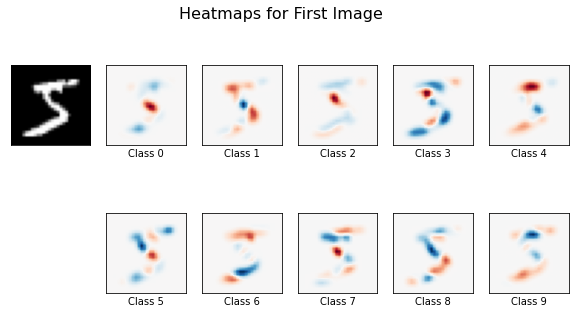

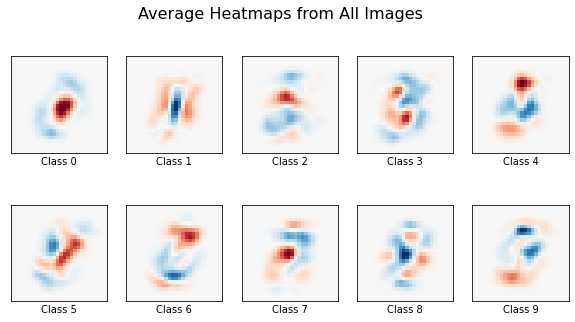

In [6]:
app(
    X[0:20],
    image_classifier_log,
    gen_slidingWindow
)

# MLP
## Fitting the Model

Following the second [example](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html#sphx-glr-auto-examples-neural-networks-plot-mnist-filters-py) from scikit-learn, we training an `MLPClassifier` on the MNIST dataset using the same hyperparameters.

To shorten training time, the MLP has only one hidden layer with 50 nodes, and is only trained for 10 iterations, meaning the model does not converge.

In [7]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier

# use the traditional train/test split
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)

# this example won't converge because of CI's time constraints, so we catch the
# warning and are ignore it here
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning,
                            module="sklearn")
    mlp.fit(X_train, y_train)

print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

Iteration 1, loss = 0.32009978
Iteration 2, loss = 0.15347534
Iteration 3, loss = 0.11544755
Iteration 4, loss = 0.09279764
Iteration 5, loss = 0.07889367
Iteration 6, loss = 0.07170497
Iteration 7, loss = 0.06282111
Iteration 8, loss = 0.05530788
Iteration 9, loss = 0.04960484
Iteration 10, loss = 0.04645355
Training set score: 0.986800
Test set score: 0.970000


## Blackbox Classifier

We wrap our `MLPClassifier` object in [SMQTK-Classifier's](https://smqtk-classifier.readthedocs.io/en/stable/classifier_interfaces.html#classifyimage) `ClassifyImage` class to comply with the API's interface.

In [8]:
class MNISTClassifierMLP (ClassifyImage):
    def get_labels(self):
        return list(range(10))
    
    def classify_images(self, image_iter):
        # Yes, "images" in this example case are really 1-dim (28*28=784).
        # MLP input needs a (n_samples, n_features) matrix input.
        images = np.asarray(list(image_iter))  # may fail because input is not consistent in shape
        images = images.reshape(-1, 28*28)  # may fail because input was not the correct shape
        return (
            {idx: p_i for idx, p_i in zip(range(10), p)}
            for p in mlp.predict_proba(images)
        )
    
    # Required for implementation
    def get_config(self):
        return {}
    
image_classifier_mlp = MNISTClassifierMLP()

## Calling the Application

We call our application again using the same image set and saliency generator, but this time using our MLP classifier.

The results show mostly negative saliency, suggesting that the MLP model has learned where the pixels are *absent* for each class more than where they are present.

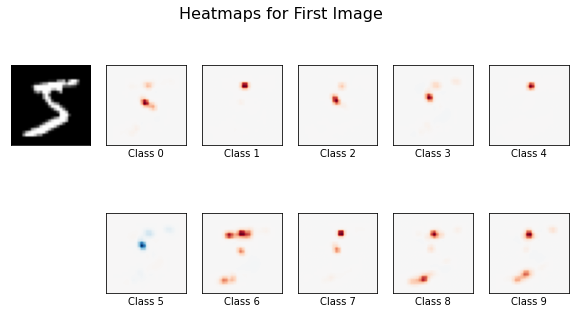

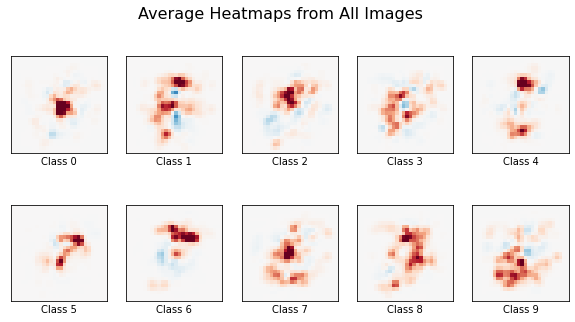

In [9]:
app(
    X[0:20],
    image_classifier_mlp,
    gen_slidingWindow
)